# Analyzing a Telegram Group Chat

In [13]:
# !pip install germansentiment

import json
import pandas as pd
import matplotlib.pyplot as plt

     ---------------------------------------- 0.0/126.8 kB ? eta -:--:--
     ---------------------------- ---------- 92.2/126.8 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 126.8/126.8 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
    --------------------------------------- 0.2/8.2 MB 4.6 MB/s eta 0:00:02
   - -------------------------------------- 0.4/8.2 MB 3.7 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/8.2 MB 3.7 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/8.2 MB 4.5 MB/s eta 0:00:02
   ---- ----------------------------------- 1.0/8.2 MB 3.9 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.2 MB 4.6 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/8.2 MB 4.7 MB/s eta 0:00:02
   --------- ------------------------------ 1.9/8.2 MB 4.8 MB/s eta 0:00:02
   ---------- ----------------------------- 2.2/8.2 MB 4.9 MB/s eta 0:00:02
   -----------


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data collection

On the desktop version of Telegram select the caht you want to analyze. 

Go to to right corner and select the drop down ... menu and then "export caht history"

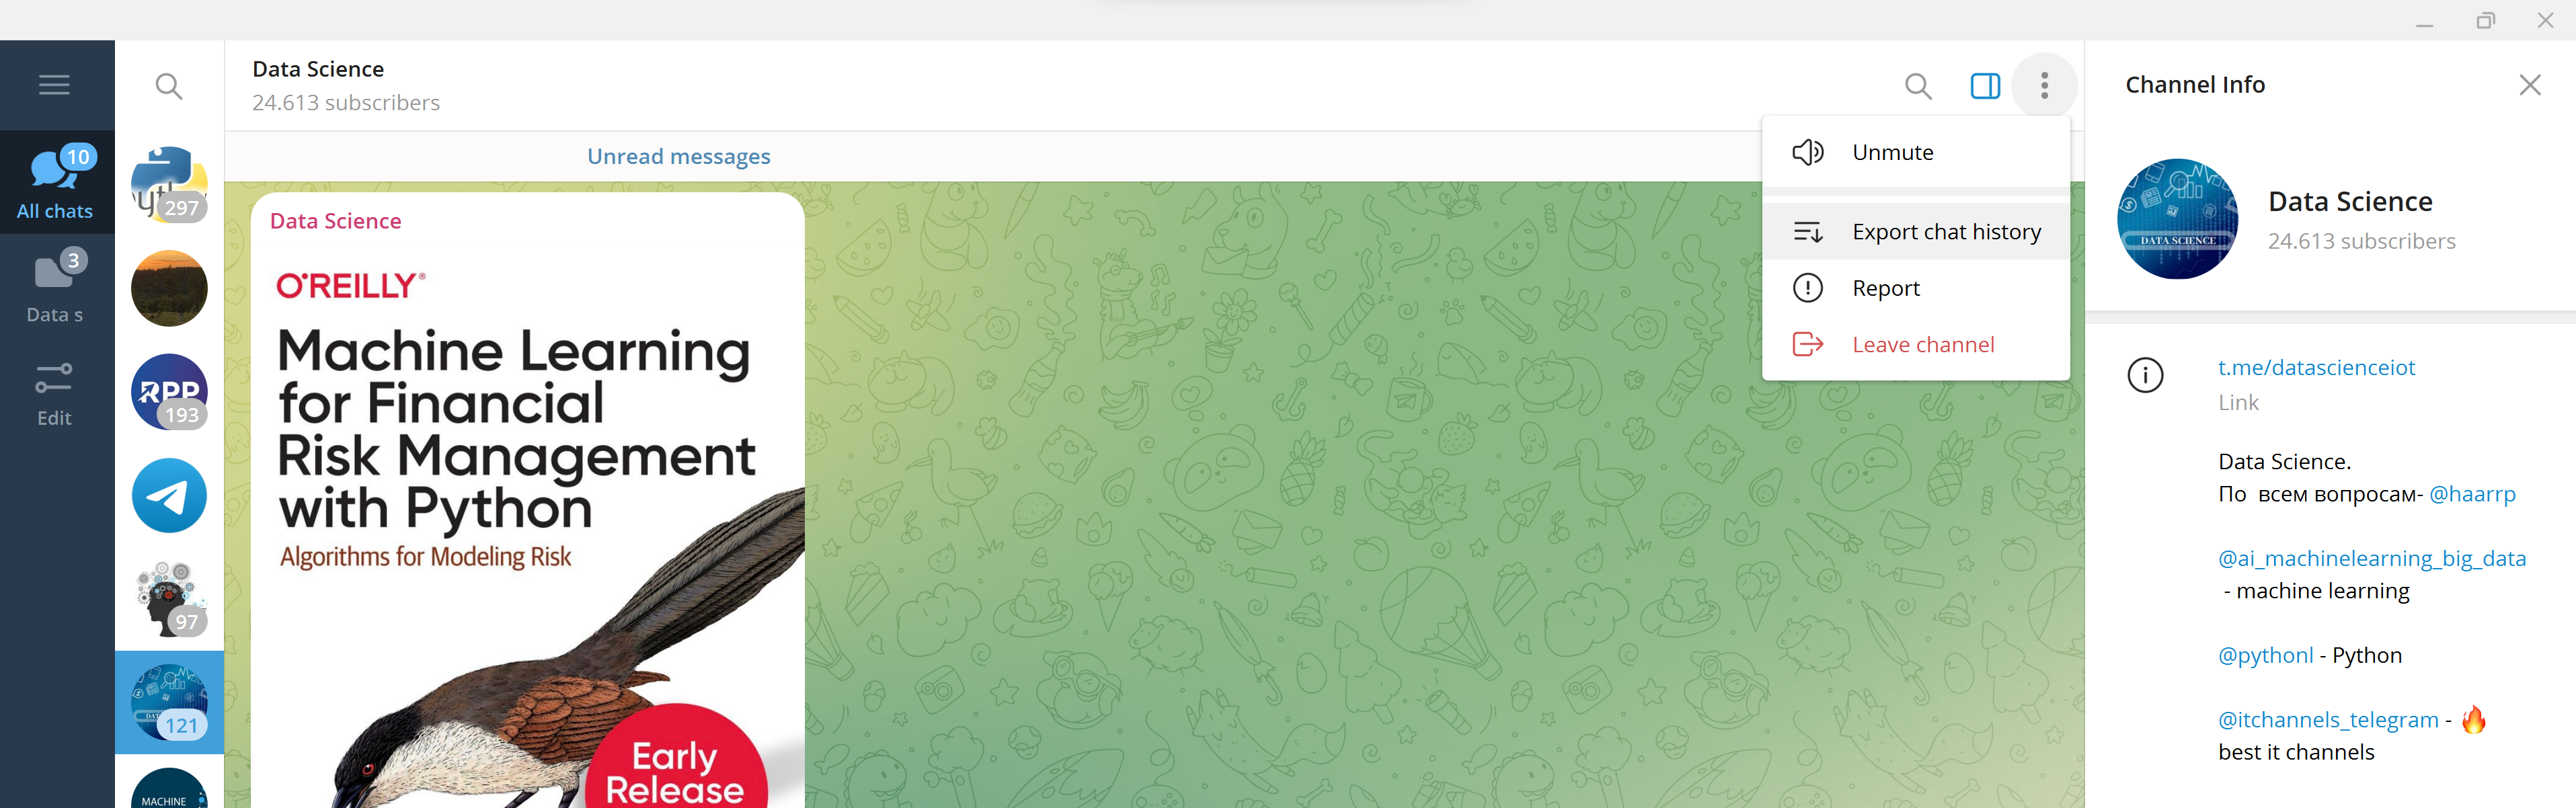

For this Notebook, we will only look at text messages, so selecting different is optional. 

Click on format and select "Machine-readable JSON" 

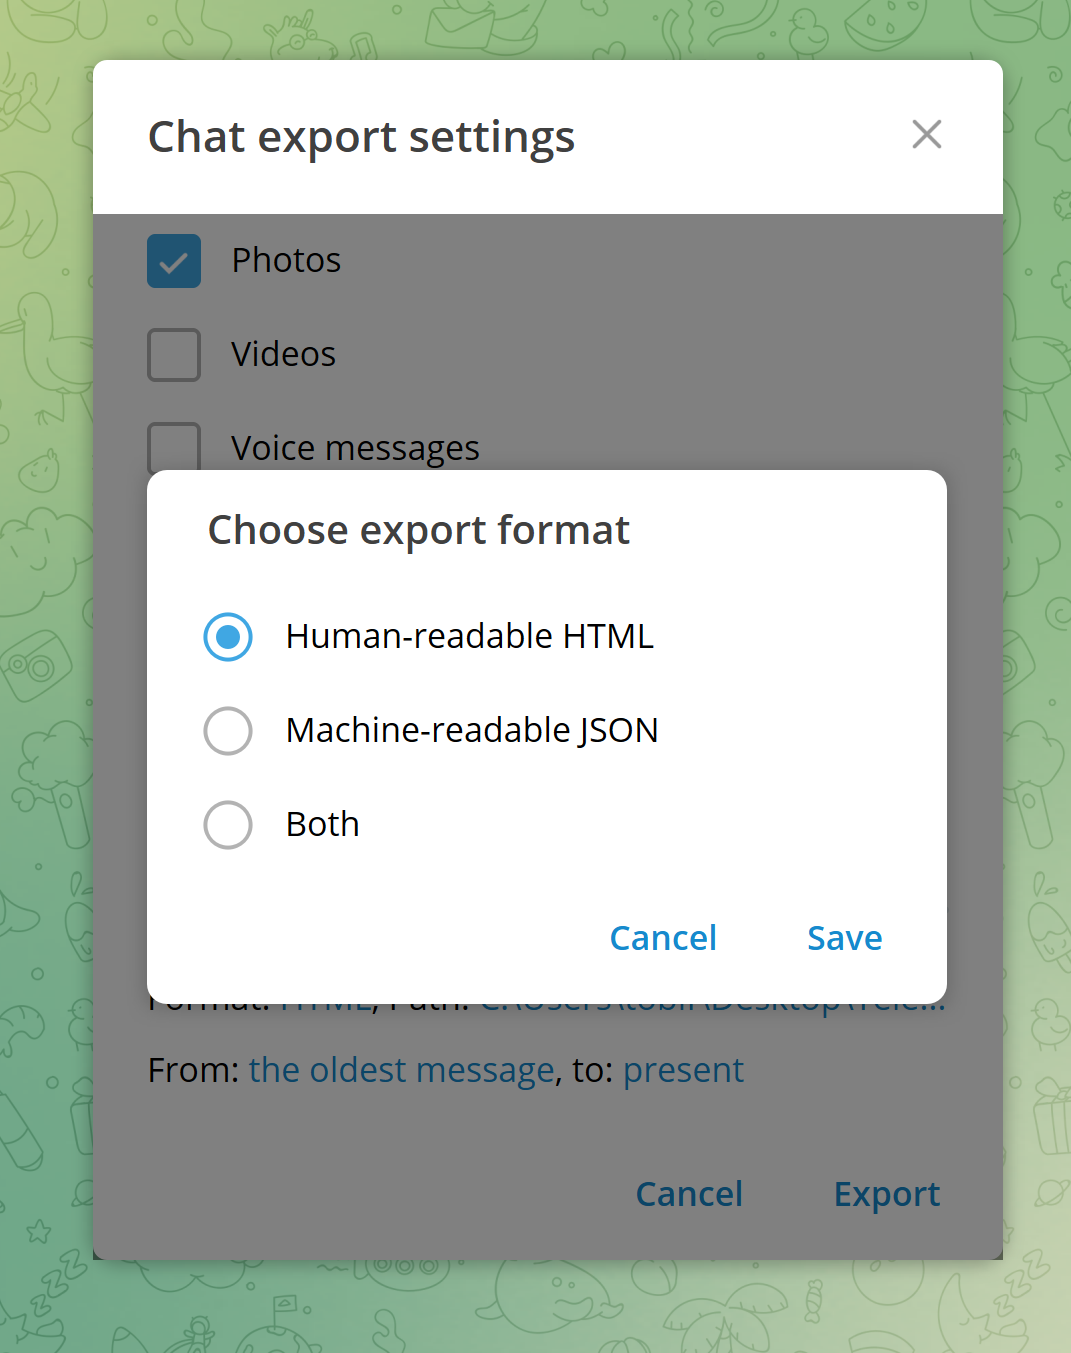

Then determine the path and begin the export. 

Once complete the messages will be stored in a ChatExport_YYYY_MM_DD folder in a result.json file. 

From here onwards we will work with this file. 

## Data transformation

In [155]:
json_path = "./result.json"

with open('./result.json', 'r', encoding="utf8") as f:
    data = json.load(f)
df = pd.DataFrame(data["messages"])


In [150]:

# The following code loops through this dictionary to extract the text elements. 
def get_message_text_from_json(data):
    '''
    For this applied case, the input should be data["message"].
    Hence the part of the json data which contains message information. 
    If a person is being referenced, the text is stored as another dictionary. 
    The function then goes through all lines extract the message text from all types of messages.
    '''
    data_message_text = []
    for i in data: 
        try:
            i["text"][0]["text"]
        except TypeError:
            message_text = i["text"]
        except IndexError:
            message_text = i["text"]
        else:
            odd_case = i["text"]
            odd_case_text = ""
            for j in odd_case:
                try:
                    j["text"]
                except TypeError:
                    odd_case_text += j
                else: 
                    odd_case_text += j["text"]
            message_text = odd_case_text
        data_message_text.append(message_text)
    return data_message_text
            


In [156]:
df["text_cleaned"] = get_message_text_from_json(data["messages"])

#checking if the lines are still alligned
print(df["text_cleaned"])
print("")
print(df["text"])

In [162]:
df.columns

Index(['id', 'type', 'date', 'date_unixtime', 'actor', 'actor_id', 'action',
       'title', 'text', 'text_entities', 'edited', 'edited_unixtime', 'from',
       'from_id', 'forwarded_from', 'reply_to_message_id', 'photo', 'width',
       'height', 'file', 'mime_type', 'thumbnail', 'media_type',
       'sticker_emoji', 'location_information', 'members', 'via_bot',
       'duration_seconds', 'game_title', 'game_description', 'game_link',
       'inline_bot_buttons', 'game_message_id', 'score', 'contact_information',
       'contact_vcard', 'poll', 'inviter', 'message_id',
       'live_location_period_seconds', 'text_cleaned'],
      dtype='object')

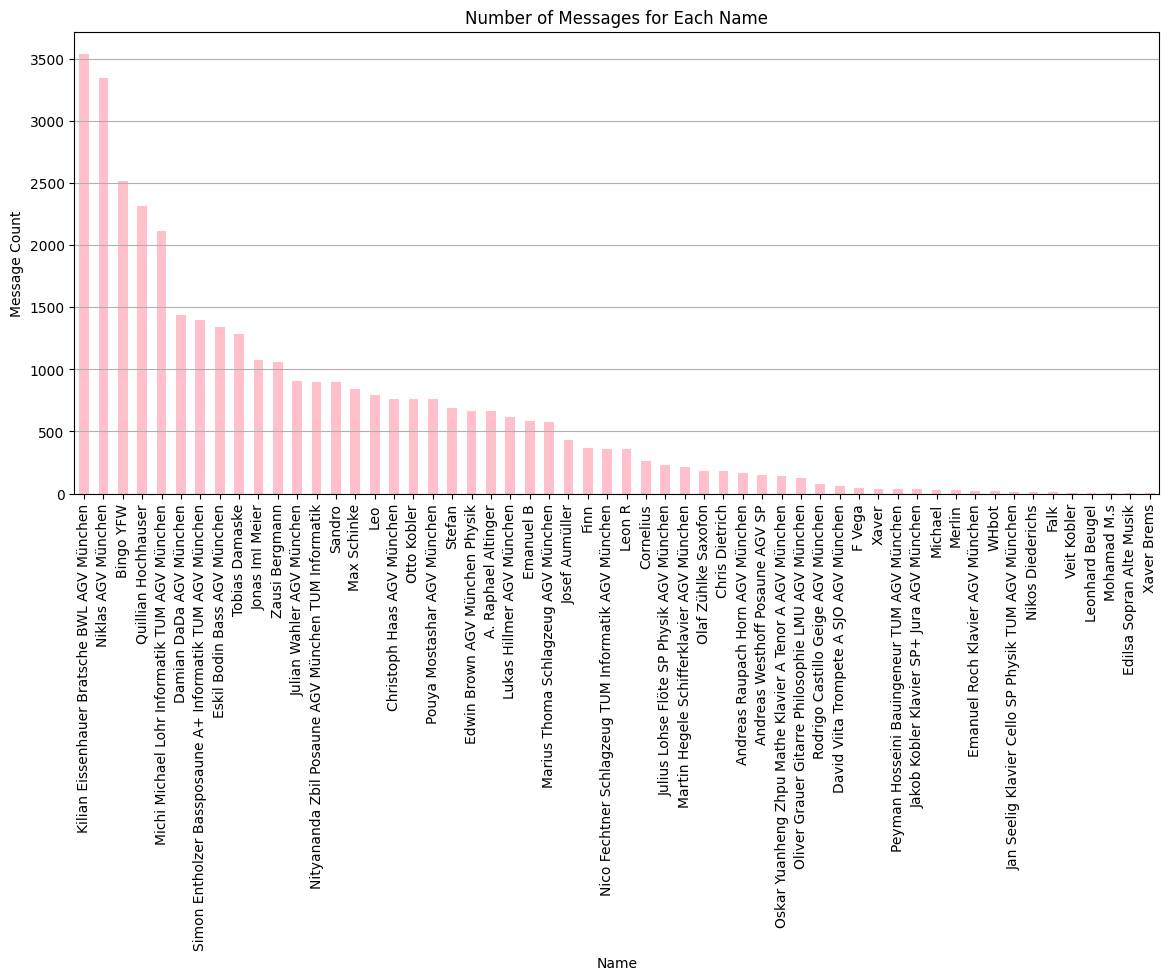

In [163]:
name_counts = df['from'].value_counts()

# Plot the bar plot
name_counts.plot(kind='bar', figsize=(14, 6), color="pink")
plt.title('Number of Messages for Each Name')
plt.xlabel('Name')
plt.ylabel('Message Count')
plt.grid(axis='y')
plt.show()

In [166]:
from germansentiment import SentimentModel
from numpy import NaN
import math

model = SentimentModel()

text = ["so ein Idiot", "Da ich ja die gelebten Prinzipien möglichst vollständig abbilden wollte.", "nein!", "ja", "komm schon Leute, das kann doch nicht sein.", "Wünsche euch einen herrlichen tag", "dies ist neutral"]

predictions = model.predict_sentiment(texts=text, output_probabilities = True)


positive_scores = []
negative_scores = []
neutral_scores = []

for i in predictions[1]:
    positive_scores.append(i[0][1])
    negative_scores.append(i[1][1])
    neutral_scores.append(i[2][1])

positive_scores = pd.DataFrame(positive_scores)
negative_scores = pd.DataFrame(negative_scores)
neutral_scores = pd.DataFrame(neutral_scores)
print(positive_scores)
print(negative_scores)
print(neutral_scores)

print(predictions[0])


          0
0  0.025326
1  0.000069
2  0.013663
3  0.403851
4  0.026582
5  0.800755
6  0.000091
          0
0  0.974617
1  0.000199
2  0.986062
3  0.582984
4  0.971586
5  0.109791
6  0.000272
          0
0  0.000057
1  0.999733
2  0.000274
3  0.013164
4  0.001832
5  0.089454
6  0.999637
['negative', 'neutral', 'negative', 'negative', 'negative', 'positive', 'neutral']


In [170]:
# I run into a memory problem here while trying to predict all chat messages at once.
# at this point one should use a gpu

test_texte = df["text_cleaned"][0:100]
test_texte = test_texte.astype(str)
test_texte = test_texte.replace("", "dies ist neutral")
text_message_sentiment = model.predict_sentiment(texts=test_texte, output_probabilities=True)

positive_scores = []
negative_scores = []
neutral_scores = []

for i in text_message_sentiment[1]:
    positive_scores.append(i[0][1])
    negative_scores.append(i[1][1])
    neutral_scores.append(i[2][1])

positive_scores = pd.DataFrame(positive_scores)
negative_scores = pd.DataFrame(negative_scores)
neutral_scores = pd.DataFrame(neutral_scores)


test_df = pd.DataFrame()
test_df["text_cleaned"] = test_texte
test_df["text_cleaned"] = test_df["text_cleaned"].replace("dies ist neutral", "")
test_df["message_sentiment_rating"] = text_message_sentiment[0]
test_df["message_positive_score"] = positive_scores
test_df["message_negative_score"] = negative_scores
test_df["message_neutral_score"] = neutral_scores

test_df

,text_cleaned,message_sentiment_rating,message_positive_score,message_negative_score,message_neutral_score
0,,neutral,0.000091,0.000272,0.999637
1,endlich 🎉,positive,0.988362,0.011545,0.000093
2,mach mal nur den WH-X zum Admin,positive,0.958295,0.040799,0.000906
3,Ist heute angekommen. Seife gibts auch wieder ...,neutral,0.009563,0.026197,0.964240
4,Ham wir kein Spüli mehr?,negative,0.023465,0.967486,0.009049
...,...,...,...,...,...
95,Sandro @MLohr und ich,neutral,0.200589,0.275460,0.523951
96,könnt ihr den HM bitte fragen ob wir einen Eis...,negative,0.218595,0.629983,0.151422
97,,neutral,0.000091,0.000272,0.999637
98,nice,positive,0.984099,0.015811,0.000090


Because the word "ja" is classified as positive, but with a small probability margin, I will calculate a sentiment score. Negative probabilities get a negative become subtracted, positive ones added. neutral is excluded. 

option 2: 
I average out all the positive scores, all the negative scores and all the neutrals. 